In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [ ]:
df = pd.read_csv('/content/META.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1615 non-null   object 
 1   Open       1615 non-null   float64
 2   High       1615 non-null   float64
 3   Low        1615 non-null   float64
 4   Close      1615 non-null   float64
 5   Adj Close  1615 non-null   float64
 6   Volume     1615 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,116.029999,117.839996,115.510002,116.860001,116.860001,20663900.0
1,2017-01-04,117.550003,119.660004,117.290001,118.690002,118.690002,19630900.0
2,2017-01-05,118.860001,120.949997,118.320000,120.669998,120.669998,19492200.0
3,2017-01-06,120.980003,123.879997,120.029999,123.410004,123.410004,28545300.0
4,2017-01-09,123.550003,125.430000,123.040001,124.900002,124.900002,22880400.0
...,...,...,...,...,...,...,...
1610,2023-05-26,252.929993,262.309998,252.710007,262.040009,262.040009,25727200.0
1611,2023-05-30,265.250000,268.649994,261.290009,262.519989,262.519989,23816500.0
1612,2023-05-31,260.000000,265.000000,258.450012,264.720001,264.720001,25473700.0
1613,2023-06-01,265.899994,274.000000,265.890015,272.609985,272.609985,25609500.0


In [ ]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'})

In [ ]:
# 3. Scaler 
data_close = df.filter(['Close'])
data = data_close.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data)


In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(scaled_data))
test_size = int(0.2 * len(scaled_data))
val_size = len(scaled_data) - train_size - test_size

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:train_size+test_size]
val_data = scaled_data[train_size+test_size:]

train_size, test_size, val_size

(1130, 323, 162)

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+50

time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1079, 50, 1)
y_train Shape:  (1079, 1)
X_test Shape:   (272, 50, 1)
y_test Shape:   (272, 1)


In [ ]:
def define_model():
    input1 = Input(shape=(time_step,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 


9/9 [==============================] - 1s 27ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
import math
from math import sqrt

MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSE = sqrt(mean_squared_error(y_test,y_pred))
MSE = mean_squared_error(y_test,y_pred)

Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print('---------------------')
print("Test RMSE:", RMSE)
print("Test MSE:", MSE)
print("Test MAPE:", MAPE)
print('---------------------')
print("Test Accuracy:", Accuracy)

Test Loss: 0.022691121324896812
---------------------
Test RMSE: 0.15063572307446949
Test MSE: 0.022691121066168256
Test MAPE: 0.19611039834144695
---------------------
Test Accuracy: 0.803889601658553


In [ ]:
y_pred_val = model.predict(X_val) 

y_test_true = scaler.inverse_transform(y_test)
# y_val_tre = scaler.inverse_transform(y_val)

y_test_pred = scaler.inverse_transform(y_pred)
y_val_pred = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 46ms/step


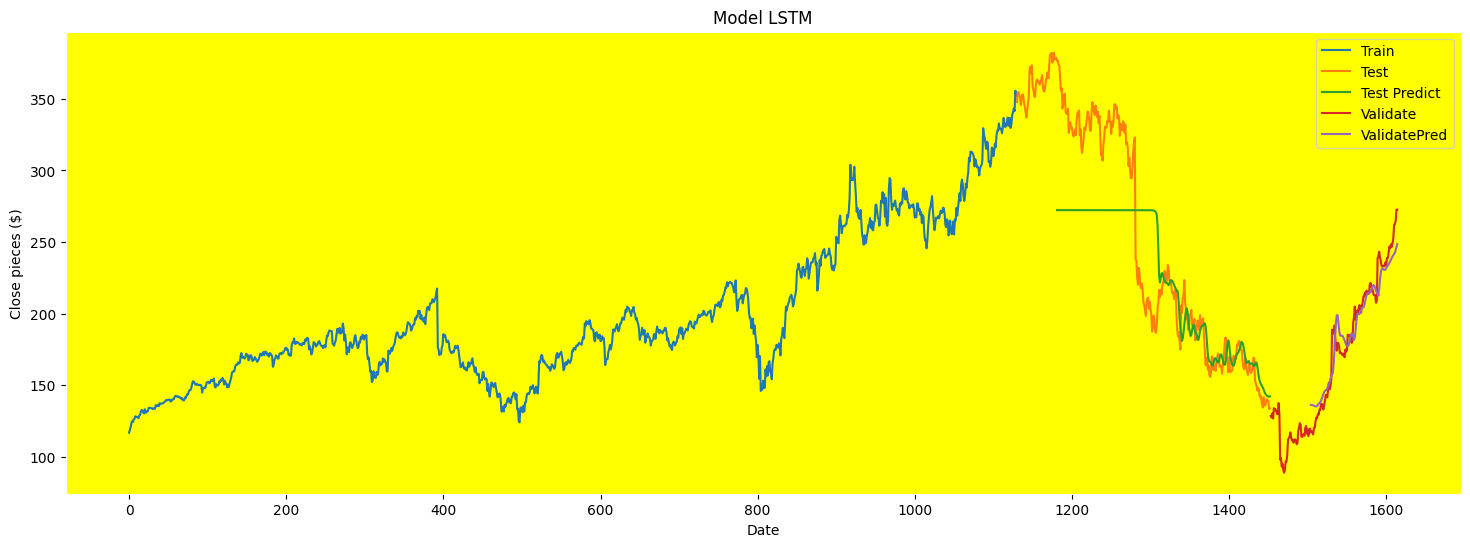

In [ ]:

plt.figure(figsize=(18,6))
plt.title("Model LSTM")

plt.xlabel('Date')
plt.ylabel("Close pieces ($)")

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+51, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_test_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+51, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_val_pred)



plt.legend(['Train','Test','Test Predict','Validate','ValidatePred','Predict30days'])
plt.show()